###  Gestion des incertitudes et analyse de risque MAP568 - (2022-2023)
#### Projet de MAP568  janvier-mars 2023

### Membres du Groupe
##### GNABEYEU MBIADA Emmanuel
##### 


##### 1 Introduction

Le but de ce projet est d’effectuer une calibration bayésienne d’un modèle d'évolution issu de l’écologie, en utilisant les outils présent ́es dans le cours. On va considérer les équations de prédation de Lotka-Volterra, qui sont utilisées pour décrire la dynamique de systèmes biologiques dans lesquels un prédateur et sa proie interagissent, et des donn ́ees disponibles en ligne.


##### Import useful librarY

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm,norm
import matplotlib.pyplot as plt
from scipy.stats import norm

import sympy as sym
from scipy.integrate import odeint  # for comparison
from scipy.integrate import solve_ivp 

from scipy.optimize import minimize

##### 2 Modèle de Lotka-Volterra

Lotka (1925) et Volterra (1926) ont formulé des équations différentielles paramétriques qui caract ́erisent la dynamique des populations de pr ́edateurs et de proies. On va effectuer une inférence bayésienne complète pour résoudre le problème inverse de l’inférence des paramètres à partir de données bruitées.
Dans le modèle de Lotka-Volterra, l’évolution des populations est régie par :


\begin{cases}
\dfrac{\mathrm{d}y(t)}{\mathrm{d}t} &=& y(t)\ \Big(\alpha - \beta z(t)\Big) \\
\dfrac{\mathrm{d}z(t)}{\mathrm{d}t} &=& z(t) \ \Big( \delta y(t) - \gamma\Big) 
\end{cases}



Où:
- y(t), l’effectif des proies en fonction du temps,
- z(t), l’effectif des prédateurs en fonction du temps.

Les variables y(t) et z(t) sont les sortie observées (avec bruit de mesure).
Les paramètres suivants caractérisent les interactions entre les deux espèces :
- $\alpha$, taux de reproduction intrinsèque des proies (constant, indépendant du nombre de prédateurs),
- $\beta$, taux de mortalité des proies du aux prédateurs rencontrées,
- $\delta$, taux de reproduction des prédateurs en fonction des proies rencontrées et mangées, 
- $\gamma$, taux de mortalit ́e intrinsèque des prédateurs (constant, ind ́ependant du nombre de proies).


##### 3 Propagation d’incertitudes

Question 1 : Programmez la résolution du système (1) avec t0 = 1900 (l’unité de temps est l’année).

Le systeme peut se mettre sous la forme d'ED0 d'equation  $X'=f(t,X)$ 
avec X=$ [y(t),z(t)]$ pour tout t

In [2]:
# Fonction qui définit l'équation de Lotka-Volterra
def lotka_volterra(X, t, params):
    alpha, beta, delta, gamma = params
    y, z = X
    dydt = y * (alpha - beta * z)
    dzdt = z * (delta * y - gamma)
    return np.array([dydt, dzdt])

> Parameters of the model  (further determine by Calibration over the Data)

![Screenshot%202023-02-16%20at%2013.01.33.png](attachment:Screenshot%202023-02-16%20at%2013.01.33.png)

On a $ X \sim \mathcal{LN}(\lambda,\zeta^2)$ ssi $lnX \sim \mathcal N (\lambda,\zeta^2).$
On a alors $\mu = \mathbb E \ [X] = exp(\lambda+\zeta^2/2)$ et $\sigma^2 = Var(X) = exp(2\lambda + \zeta^2)(exp(\zeta^2) − 1).$

En utilisant les expressions de $\mu$ et $\sigma^2$, on a:
$$\mu = exp(\lambda+\zeta^2/2) \Longrightarrow \lambda = \log(\mu) - \frac{\zeta^2}{2}$$
et
$$\sigma^2 = exp(2\lambda + \zeta^2)(exp(\zeta^2) − 1) \Longrightarrow \zeta^2 = \log\Bigg(\frac{\sigma^2}{\mu^2} + 1\Bigg).$$
Finalement, en remplaçant $\lambda$ par l'expression obtenue pour $\lambda$ dans la seconde expression, on obtient:
$$\zeta^2 = \log\Bigg(\frac{\sigma^2}{\mu^2} + 1\Bigg)$$
et
$$\lambda = \log(\mu) - \frac{\log\Big(\frac{\sigma^ 2}{\mu^ 2} + 1\Big)}{2}.$$

In [3]:
# Définition des paramètres d'entrée de la loi normale associée à la loi log-normale.
alpha_mean = np.log(0.5/(1 + 0.2**2/0.5**2)**0.5)
alpha_var = np.log((0.2**2/0.5**2 + 1))
gamma_mean = np.log(0.5/(1 + 0.2**2/0.5**2)**0.5)
gamma_var = np.log((0.2**2/0.5**2 + 1))
beta_mean = np.log(0.05/(1 + 0.02**2/0.05**2)**0.5)
beta_var = np.log((0.02**2/0.05**2 + 1))
delta_mean =np.log(0.05/(1 + 0.02**2/0.05**2)**0.5)
delta_var = np.log((0.02**2/0.05**2 + 1))
y0_mean = np.log(10)
y0_var = 1
z0_mean = np.log(10)
z0_var = 1

# Génération des échantillons des paramètres d'entrée
def init():
    # Paramètres de l'équation de Lotka-Volterra
    alpha_init = np.random.lognormal(mean= alpha_mean, sigma=np.sqrt(alpha_var), size=1)[0]
    beta_init = np.random.lognormal(mean= beta_mean , sigma=np.sqrt(beta_var),size=1)[0]
    gamma_init = np.random.lognormal(mean=gamma_mean, sigma=np.sqrt(gamma_var), size=1)[0]
    delta_init = np.random.lognormal(mean= delta_mean, sigma=np.sqrt(delta_var), size=1)[0]
    # Population initiale des proies et des prédateurs
    y0_init = np.random.lognormal(mean=y0_mean, sigma=np.sqrt(y0_var),size=1)[0]
    z0_init = np.random.lognormal(mean=z0_mean, sigma=np.sqrt(z0_var), size=1)[0]
    return np.array([alpha_init, beta_init, delta_init, gamma_init, y0_init,z0_init])

In [4]:
np.random.lognormal(mean=0.5, sigma=0.2, size=1)

array([1.3542518])

In [5]:
# Paramètres de l'équation de Lotka-Volterra
alpha, beta, gamma, delta,y0,z0= init()

params = [alpha, beta, gamma, delta]
X0 = np.array([y0, z0])

Lorsque ces 6 paramètres sont fixés, on obtient une trajectoire des variables de sortie y(t), z(t) par r ́esolution du système (1).

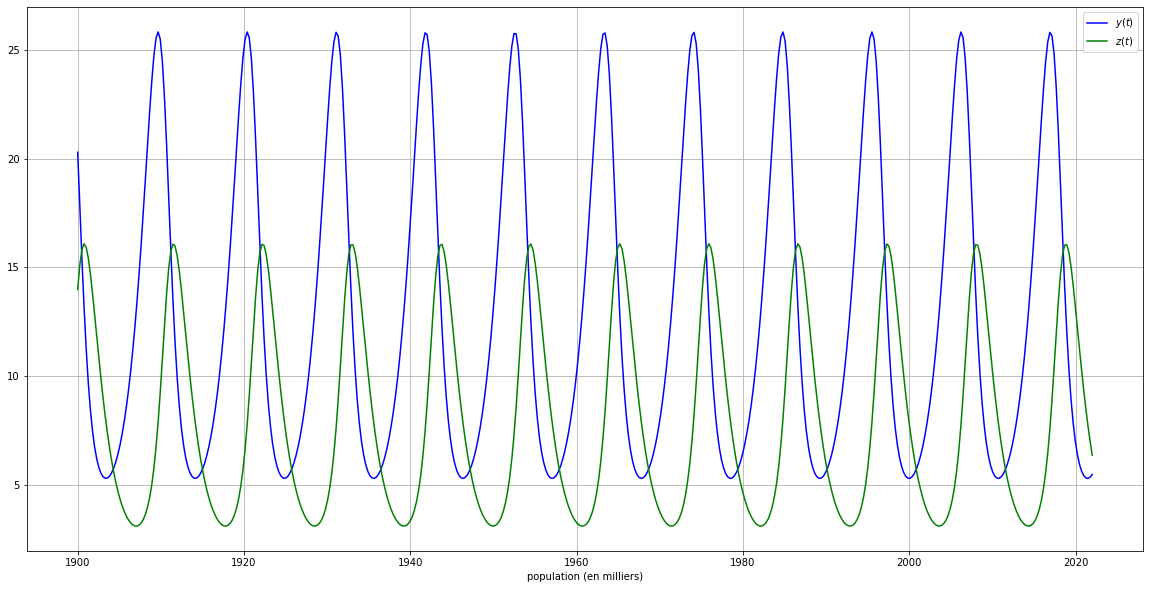

In [ ]:
t = np.linspace(1900, 2022, 480)

sol = odeint(lotka_volterra, [y0, z0],t , args=(params,))
plt.figure(figsize=(20,10))
plt.plot(t, sol[:, 0], 'b', label=r'$y(t)$')
plt.plot(t, sol[:, 1], 'g', label=r'$z(t)$')
plt.legend(loc='best')
plt.xlabel('date (en années)')
plt.xlabel('population (en milliers)')
plt.grid()
plt.show()

La fonction utilise la fonction odeint du module scipy.integrate pour résoudre l'équation différentielle de Lotka-Volterra à l'aide de la méthode Runge-Kutta d'ordre 4, que nous pouvons nous-meme implémenter comme ci-dessous.

#### Runge-Kutta method of order 4 or "RK4"
The order 4 Runge-Method uses this update:
$y_{n+1}=y_n+\frac{h}{6}(k_1+2k_2+2k_3+k_4)$,

if  $h=t_{n+1} − t_n$ , and  

\begin{cases}
k_1 & = & f(t_n,y_n),\\
        k_2 & = & f(t_n+\frac{h}{2},y_n+\frac{h}{2}k_1),\\
        k_3 & = & f(t_n+\frac{h}{2},y_n+\frac{h}{2}k_2),\\
        k_4 & = & f(t_n+h,y_n+hk_3)
\end{cases}

In [7]:
def rungekutta4(f, x0, t, args=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(x[i], t[i], *args)
        k2 = f(x[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(x[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(x[i] + k3 * h, t[i] + h, *args)
        x[i+1] = x[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return x

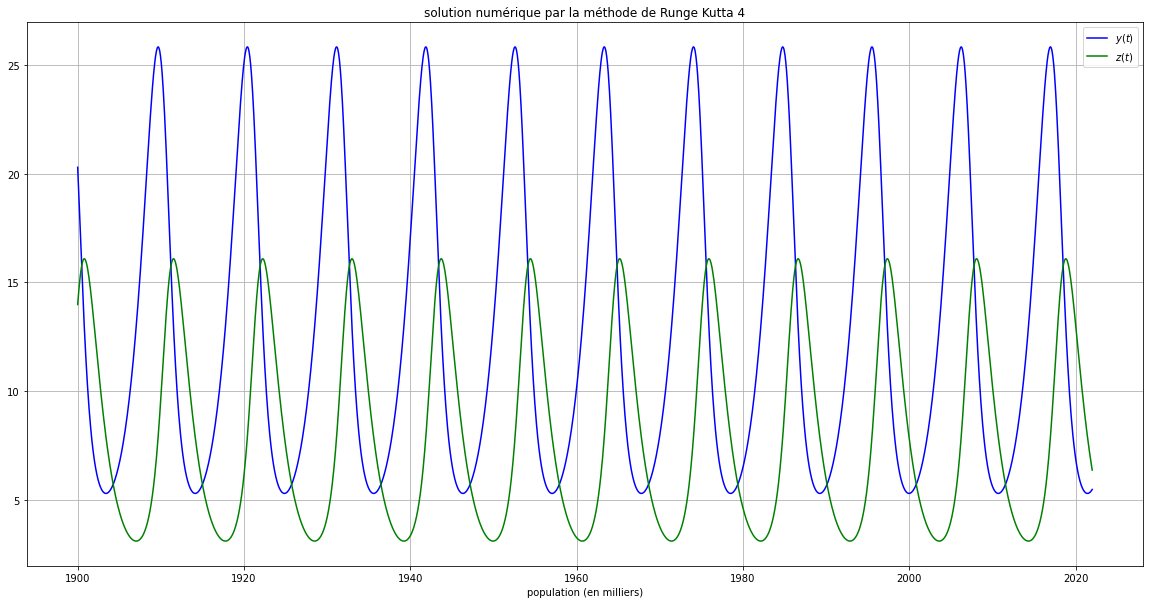

In [ ]:
t = np.linspace(1900, 2022, 2500) # convergence à partir de 480 points

sol2 = rungekutta4(lotka_volterra, X0, t, args=(params,))

plt.figure(figsize=(20,10))
plt.plot(t, sol2[:, 0], 'b', label=r'$y(t)$')
plt.plot(t, sol2[:, 1], 'g', label=r'$z(t)$')
plt.legend(loc='best')
plt.title('solution numérique par la méthode de Runge Kutta 4') 
plt.xlabel('date (en années)')
plt.xlabel('population (en milliers)')
plt.grid()
plt.show()

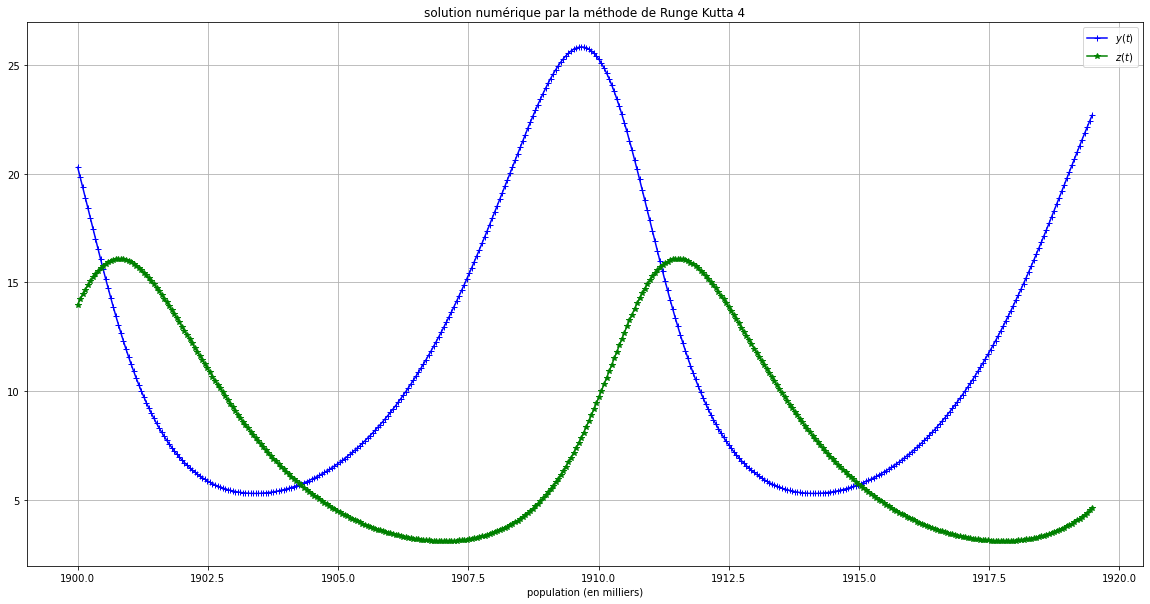

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(t[:400], sol2[:, 0][:400], 'b',marker='+', label=r'$y(t)$')
plt.plot(t[:400], sol2[:, 1][:400], 'g', marker='*',label=r'$z(t)$')
plt.legend(loc='best')
plt.title('solution numérique par la méthode de Runge Kutta 4') 
plt.xlabel('date (en années)')
plt.xlabel('population (en milliers)')
plt.grid()
plt.show()

#### Solution d'Euler:

In [48]:
def lotka_volterra3(y, z, alpha, beta, gamma, delta):
    doty = y * (alpha - beta * z)
    dotz = z * (delta * y - gamma)

    return [doty, dotz]

h = 0.01  
# Résolution du système par le shéma d'Euler
def resolution(X_, tfinal):
    t = np.arange(t0, tfinal+h, h)
    alpha, beta, delta, gamma, y0, z0 = X_
    s = z0.shape[0]

    # initialiser les premières valeurs de y et z avec les valeurs initiales y_0 et z_0
    y, z = np.zeros((s,len(t))) , np.zeros((s,len(t)))
    y[:,0], z[:,0] = y0 ,z0

    # résoudre le système d'équations différentielles en utilisant la méthode d'Euler    
    for i in range(1, len(t)):
        dy, dz = lotka_volterra3(y[:,i-1], z[:,i-1], alpha, beta, gamma, delta)
        y[:,i] = y[:,i-1] + h * dy
        z[:,i] = z[:,i-1] + h * dz
    
    return y, z

#### Resolution par Monte Carlo

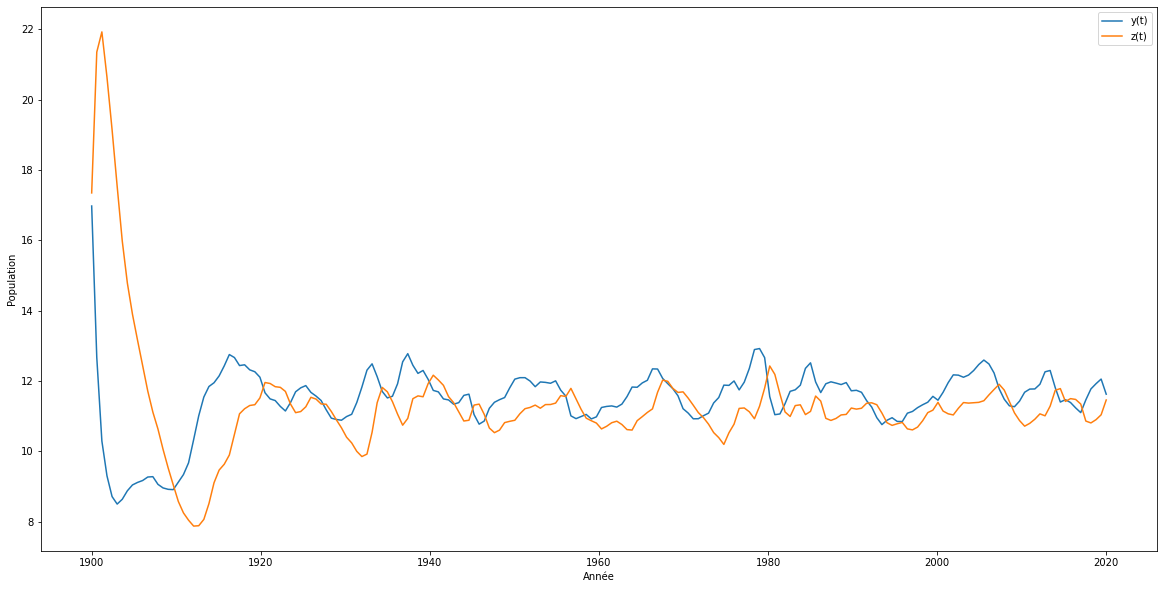

In [ ]:
# Monte Carlo pour résoudre l'équation de Lotka-Volterra et tracer:
num_samples=1000
# Durée de la simulation et pas de temps
t = np.linspace(1900, 2020, 200)
dt = t[1] - t[0]

# Tableaux pour stocker les populations de proies et de prédateurs à chaque pas de temps
y = np.zeros_like(t)
z = np.zeros_like(t)
# alpha, beta, delta, gamma, y0,z0 = init()
# Génération des échantillons des paramètres d'entrée
alpha_samples = np.random.lognormal(mean=alpha_mean, sigma=np.sqrt(alpha_var), size=num_samples)
beta_samples = np.random.lognormal(mean=beta_mean, sigma=np.sqrt(beta_var),size=num_samples)
gamma_samples = np.random.lognormal(mean=gamma_mean, sigma=np.sqrt(gamma_var), size=num_samples)
delta_samples = np.random.lognormal(mean=delta_mean, sigma=np.sqrt(delta_var), size=num_samples)
y0_samples = np.random.lognormal(mean=y0_mean, sigma=np.sqrt(y0_var),size=num_samples)
z0_samples = np.random.lognormal(mean=z0_mean, sigma=np.sqrt(z0_var), size=num_samples)

# Répéter la simulation pour différents échantillons de paramètres
for i in range(num_samples):
    # Résoudre l'équation de Lotka-Volterra pour l'échantillon de paramètres actuel
    params = [alpha_samples[i], beta_samples[i], delta_samples[i],gamma_samples[i]]
    # params = [alpha, beta, gamma, delta]
    sol = odeint(lotka_volterra, [y0_samples[i], z0_samples[i]], t, args=(params,))
    # Ajouter les résultats de la simulation aux tableaux
    y += sol[:, 0]
    z += sol[:, 1]

# Diviser les résultats par le nombre d'échantillons pour obtenir la moyenne des populations de proies et de prédateurs à chaque pas de temps
y /= num_samples
z /= num_samples

# Tracer les résultats
plt.figure(figsize=(20,10))
plt.plot(t, y, label='y(t)')
plt.plot(t, z, label='z(t)')
plt.legend()
plt.xlabel('Année')
plt.ylabel('Population')
plt.show()


La population tend à s'équilibrer

Question 2 : Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d’entrée de la table 1), représentez la loi des populations de proies et prédateurs en 1900, en 1901 et en 1920.

In [11]:
# Fonction qui définit l'équation de Lotka-Volterra
def lotka_volterra_(t,X, params):
    alpha, beta, delta, gamma = params
    y, z = X
    dydt = y * (alpha - beta * z)
    dzdt = z * (delta * y - gamma)
    return np.array([dydt, dzdt])

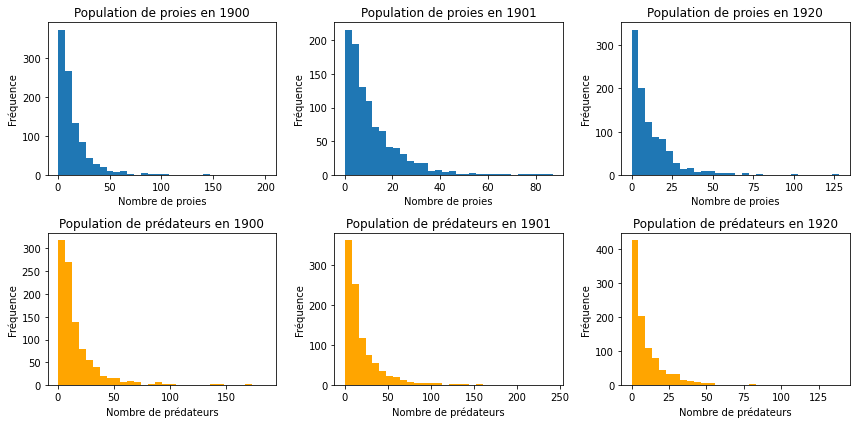

In [10]:
#  Nombre Échantillonnage Monte Carlo
num_samples = 1000
# Définition du temps
t_eval = [1900,1901,1920]
t_span=[t_eval[0], t_eval[-1]]

# Génération des échantillons des paramètres d'entrée
alpha_samples = np.random.lognormal(mean=alpha_mean, sigma=np.sqrt(alpha_var), size=num_samples)
beta_samples = np.random.lognormal(mean=beta_mean, sigma=np.sqrt(beta_var),size=num_samples)
gamma_samples = np.random.lognormal(mean=gamma_mean, sigma=np.sqrt(gamma_var), size=num_samples)
delta_samples = np.random.lognormal(mean=delta_mean, sigma=np.sqrt(delta_var), size=num_samples)
y0_samples = np.random.lognormal(mean=y0_mean, sigma=np.sqrt(y0_var),size=num_samples)
z0_samples = np.random.lognormal(mean=z0_mean, sigma=np.sqrt(z0_var), size=num_samples)

# Boucle sur les échantillons Monte Carlo
results = []
for i in range(num_samples):
    params = [alpha_samples[i], beta_samples[i], delta_samples[i],gamma_samples[i]]
    # Stockage des populations de proies et prédateurs en 1901
    # Résolution de l'équation différentielle pour l'échantillon i
    # On peut aussi utiliser notre méthode de Runge Kutta 4 ici
    sol = solve_ivp(lotka_volterra_,t_span, [y0_samples[i], z0_samples[i]], t_eval=t_eval, args=(params,))
    # Stockage des populations de proies et prédateurs en 1900,en 1901 et en 1920
    results.append(sol.y.T)

# Représentation graphique des résultats
fig, axs = plt.subplots(2, len(t_eval), figsize=(12, 6))

for i, t in enumerate(t_eval):
    x_values = [result[i, 0] for result in results]
    y_values = [result[i, 1] for result in results]
    # Histogramme des populations de proies en 190i
    axs[0, i].hist(x_values, bins=30)
    # Histogramme des populations de prédateurs en 190i
    axs[1, i].hist(y_values, bins=30,color='orange')
    axs[0, i].set_title(f"Population de proies en {t}")
    axs[1, i].set_title(f"Population de prédateurs en {t}")
    axs[0, i].set_xlabel("Nombre de proies")
    axs[0, i].set_ylabel('Fréquence')
    axs[1, i].set_xlabel("Nombre de prédateurs")
    axs[1, i].set_ylabel('Fréquence')
    

plt.tight_layout()
plt.show()

#### 4. Calibration

On va considérer des données qui concernent l’évolution des populations de lynx (prédateurs) et de lièvres (proies) entre 1900 et 1920.
Les tailles de population sont exprimées en milliers.

In [6]:
# Données
t = np.arange(1900, 1921)
# lievre
data_proie = np.array([30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
# lynx
data_preda = np.array([4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
data = np.column_stack((data_proie, data_preda))

Question 3 : Dessinez les donn ́ees collect ́ees de 1900 à 1920 (vous devez trouver quelque chose qui ressemble à la figure 1).

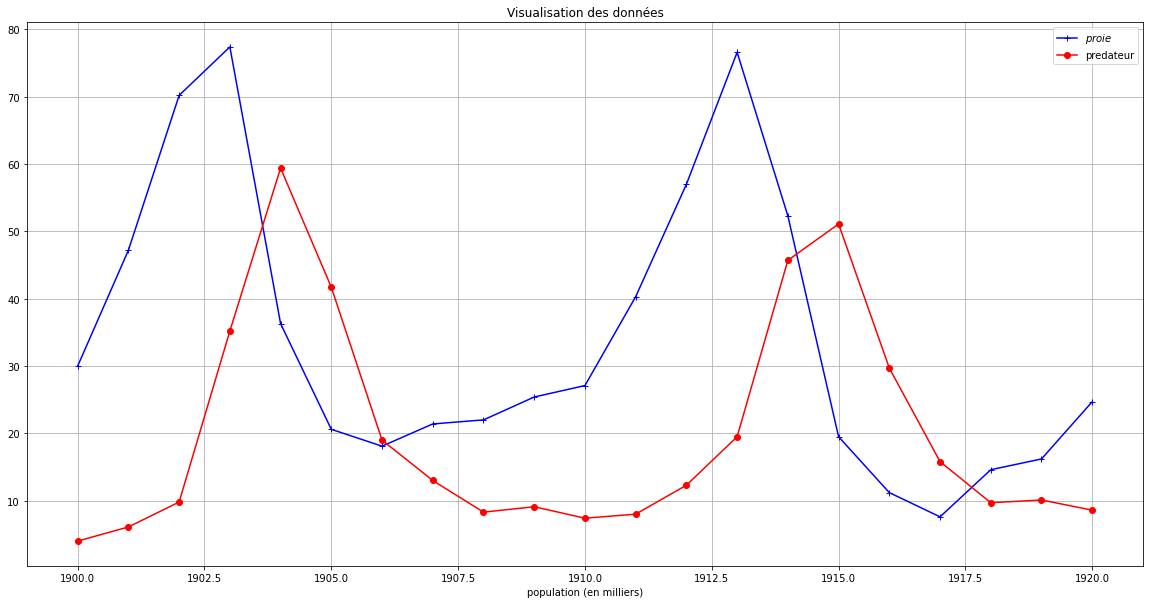

In [7]:
plt.figure(figsize=(20,10))
plt.plot(t, data_proie, 'b',marker='+', label=r'$proie$')
plt.plot(t, data_preda, 'r', marker='o',label=r'predateur')
plt.legend(loc='best')
plt.title('Visualisation des données') 
plt.xlabel('date (en années)')
plt.xlabel('population (en milliers)')
plt.grid()
plt.show()

##### 4.1 Calibration d ́eterministe

On note $t_i,\quad i = 0, . . . , 20$ les dates ou les donn ́ees sont recueillies $(t_0 = 1900, t_{20} = 1920)$. 
On cherche à ajuster au mieux le modèle au sens des moindres carrés :

$$
 \begin{array}{ccc}
    x∗ = argmin_x \mathcal E(x) \\
    \mathcal E(x) = \sum_{i=0}^{20} \quad e_{proie} \quad (x, t_i)^2 + e_{preda} \quad(x, t_i)^2, 
\end{array}
$$

ou les résidus sont définis par :
$$
\begin{equation}
\label{eq1}
 \begin{cases}
    e_{proie} \quad (x, t_i) = log \mathcal M_{proie} \quad(x, t_i) − log data_{proie}\quad(t_i), \\
   e_{preda} \quad (x, t_i) = log \mathcal M_{preda} \quad(x, t_i) − log data_{preda}\quad(t_i) 
\end{cases}
\end{equation}
$$

$
\mathcal M(x,t) = (\mathcal M _{proie} \quad(x,t),\mathcal M_{preda} \quad(x,t))$ est la prédiction à l’instant t du nombre de proies et de prédateurs par le modèle de Lotka-Volterra avec les paramètres x. Le fait de prendre le log sera expliqué dans la section suivante, cela correspond à supposer un modèle d’erreur multiplicative.
(c'est-à-dire qu'une erreur relative constante est plus plausible qu'une erreur absolue constante.)


Question 4 : Evaluez numériquement x∗ dans le domaine de $\mathbb{R}^6$ déterminé par
le support essentiel des lois a priori (l’hypercube $\prod_{j=1}^ 6 [exp(\lambda_j −2\zeta_j),exp(\lambda_j +2\zeta_j)])$.

In [8]:
def LV_model(t, x_opt):
    """
    Fonction retournant les populations de proies et prédateurs prédites par le modèle de Lotka-Volterra
    aux instants t, avec les paramètres alpha, beta, delta et gamma et les populations initiales y0.
    """
    alpha, beta, delta, gamma, y0, z0 = x_opt
    params = [alpha, beta, delta, gamma ]
    sol = odeint(lotka_volterra, [y0, z0], t, args=(params,))
    return sol

Tout d'abord, nous définissons la fonction $\mathcal{M}(x,t)$ qui calcule la prédiction des populations de proies et de prédateurs à l'instant $t$ avec les paramètres $x$ :

In [9]:
def M(x, t):
    alpha, beta, delta, gamma,y0, z0 = x
    t_span=[1900, 1920]
    params = [alpha, beta, delta, gamma]
    sol = solve_ivp(lotka_volterra_, t_span,[y0, z0], t_eval=[t] , args=(params,), rtol=1e-10, atol=1e-10)
    return [sol.y[0][0], sol.y[1][0]]

def e_proie(x, t, y):
    return np.log(M(x, t)[0]) - np.log(y[0])

def e_preda(x, t, y):
    return np.log(M(x, t)[1]) - np.log(y[1])

def E(x):
    e_proie_sum = np.sum([e_proie(x0, t, data[i,:]) ** 2 for i,t in enumerate(range(1900,1921,1))])
    e_preda_sum = np.sum([e_preda(x, t, data[i,:]) ** 2 for i,t in enumerate(range(1900,1921,1))])
    return e_proie_sum + e_preda_sum

# Calcul des prédictions du modèle
def Mpred(params, tf):
    # on résout l'équation différentielle
    y, z = resolution(params, tf)
    # y,z=odeint(lotka_volterra, [y0, z0],t , args=(params,))
    indices = np.arange(0, tf - t0 + 1) / h
    indices = indices.astype(int)

    return y[:,indices], z[:,indices]


Ici, bounds est une liste de tuples qui contient les bornes pour chaque paramètre. x0 est le point de départ pour l'optimisation, qui est choisi aléatoirement en utilisant les lois log-normales a priori. res est un objet qui contient les résultats de l'optimisation, y compris la valeur optimale de $x$.

In [12]:
# Génération des échantillons des paramètres d'entrée
# vecteur initial des paramètres à optimiser
x0 = init()

# on initialise lambdas avec les valeurs de moyenne pour chaque paramètre, 
# et zetas avec les valeurs de variance pour chaque paramètre.
# dans l'ordre $\alpha$, $\beta$, $\delta$, $\gamma$, $y_0$ et $z_0$.

lambdas = np.array([alpha_mean, beta_mean, delta_mean, gamma_mean, y0_mean, z0_mean])
zetas = np.array([alpha_var, beta_var, delta_var, gamma_var, y0_var, z0_var])**(0.5)

# Définition des bornes pour les paramètres
bounds = [(np.exp(l - 2*z), np.exp(l + 2*z)) for l, z in zip(lambdas, zetas)]


# Optimisation de la fonction E
res = minimize(E, x0, bounds=bounds)

# Affichage des résultats
print(res)

      fun: 53.382762542167434
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.57927012e-04, -1.06588516e-02,  1.48858703e-03, -7.97939488e-04,
        1.42108535e-06,  2.27373677e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 371
      nit: 43
     njev: 53
   status: 0
  success: True
        x: array([7.51503149e-01, 3.80202459e-02, 2.37490761e-02, 5.98212555e-01,
       2.42372049e+01, 5.83218820e+00])


Comparez sur une figure les données $(data_{proie} \quad (t_i ), data_{preda} \quad (t_i ))_{i=1}^{20}$ et les prédictions $\mathcal M(x∗, t).$

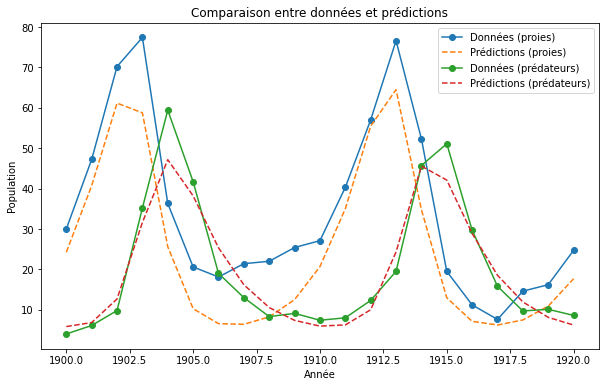

In [13]:
x_opt= res.x
t = np.arange(1900, 1921)

# Prédictions
pred = np.array([M(x_opt, ti) for ti in t])
y_pred, z_pred = LV_model(t, x_opt).T   # = M_proie,M_preda
M_proie = pred[:,0]
M_preda = pred[:,1]



# Tracer les courbes
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, data_proie, label='Données (proies)', marker='o')
ax.plot(t, M_proie, label='Prédictions (proies)', linestyle='--')
ax.plot(t, data_preda, label='Données (prédateurs)', marker='o')
ax.plot(t, M_preda , label='Prédictions (prédateurs)', linestyle='--')
ax.set_xlabel('Année')
ax.set_ylabel('Population')
ax.set_title('Comparaison entre données et prédictions')
ax.legend()
plt.show()

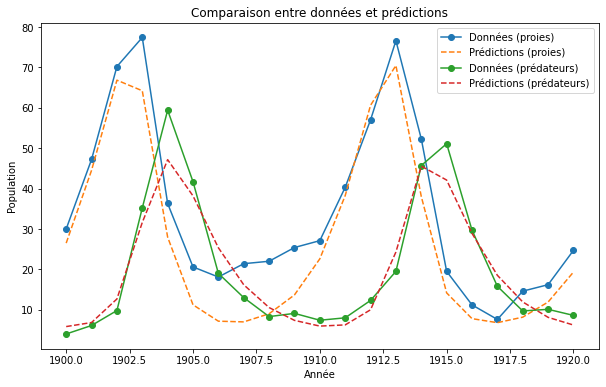

In [15]:
# x_opt= res.x
x_opt=np.array([7.51357008e-01, 3.80130873e-02, 2.17305902e-02, 5.98311254e-01,
       2.64945369e+01, 5.83206944e+00])
t = np.arange(1900, 1921)

# Prédictions
pred = np.array([M(x_opt, ti) for ti in t])
y_pred, z_pred = LV_model(t, x_opt).T   # = M_proie,M_preda
M_proie = pred[:,0]
M_preda = pred[:,1]



# Tracer les courbes
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, data_proie, label='Données (proies)', marker='o')
ax.plot(t, M_proie, label='Prédictions (proies)', linestyle='--')
ax.plot(t, data_preda, label='Données (prédateurs)', marker='o')
ax.plot(t, M_preda , label='Prédictions (prédateurs)', linestyle='--')
ax.set_xlabel('Année')
ax.set_ylabel('Population')
ax.set_title('Comparaison entre données et prédictions')
ax.legend()
plt.show()

Il est important de noter que la fonction $\mathcal{E}(x)$ peut posséder des minima locaux, donc le résultat obtenu dépend du point de départ $x_0$. Il est recommandé d'exécuter plusieurs fois l'optimisation avec différents points de départ pour s'assurer que la solution trouvée est globale. On peut en outre, juste essayer de se rassurer que le point de départ $x_0$ est dans l'hypercube donnée(support essentiel des lois à priori)

In [ ]:
lambdas = np.array([alpha_mean, beta_mean, delta_mean, gamma_mean, y0_mean, z0_mean])
zetas = np.array([alpha_var, beta_var, delta_var, gamma_var, y0_var, z0_var])**(0.5)

bounds = []
for i in range(6):
    bounds.append((np.exp(lambdas[i]-2*zetas[i]), np.exp(lambdas[i]+2*zetas[i])))

# Répéter la minimisation avec des points aléatoires
min_E = np.inf
min_x = None
for i in range(20):
    # Générer un point aléatoire dans l'hypercube de support essentiel
    x0 = init()
    # Minimiser la fonction E avec le point initial aléatoire
    res = minimize(E, x0, bounds=bounds)
    # Comparer le résultat avec le minimum global
    if res.fun < min_E:
        min_E = res.fun
        min_x = res.x

print("Minimum global de E : ", min_E)
print("Paramètres correspondants : ", min_x)

Minimum global de E :  10.311703610825848
Paramètres correspondants :  [ 0.75133418  0.03801189  0.02410003  0.59832533 23.89049856  5.83206946]


Comparez sur une figure les données $(data_{proie} \quad (t_i ), data_{preda} \quad (t_i ))_{i=1}^{20}$ et les prédictions $\mathcal M(x∗, t).$

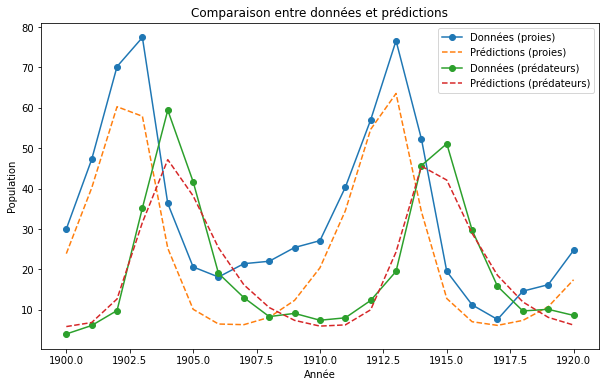

In [ ]:
x_opt= min_x
t = np.arange(1900, 1921)

# Prédictions
pred = np.array([M(x_opt, ti) for ti in t])
y_pred, z_pred = LV_model(t, x_opt).T   # = M_proie,M_preda
M_proie = pred[:,0]
M_preda = pred[:,1]



# Tracer les courbes
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, data_proie, label='Données (proies)', marker='o')
ax.plot(t, y_pred, label='Prédictions (proies)', linestyle='--')
ax.plot(t, data_preda, label='Données (prédateurs)', marker='o')
ax.plot(t, z_pred , label='Prédictions (prédateurs)', linestyle='--')
ax.set_xlabel('Année')
ax.set_ylabel('Population')
ax.set_title('Comparaison entre données et prédictions')
ax.legend()
plt.show()

Comparez sur une figure les données $(data_{proie} \quad (t_i ), data_{preda} \quad (t_i ))_{i=1}^{20}$ et les prédictions $\mathcal M(x∗, t).$

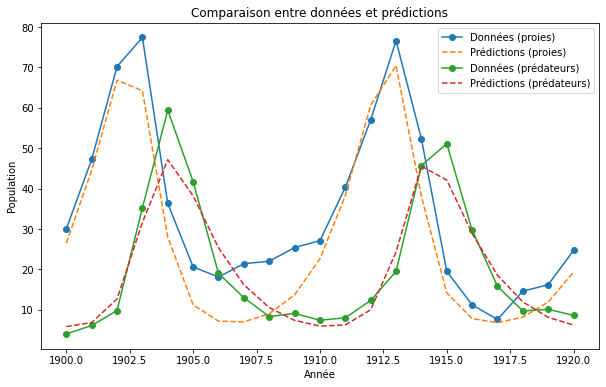

In [ ]:
x_opt= res.x
t = np.arange(1900, 1921)

# Prédictions
pred = np.array([M(x_opt, ti) for ti in t])
y_pred, z_pred = LV_model(t, x_opt).T   # = M_proie,M_preda
M_proie = pred[:,0]
M_preda = pred[:,1]



# Tracer les courbes
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, data_proie, label='Données (proies)', marker='o')
ax.plot(t, y_pred, label='Prédictions (proies)', linestyle='--')
ax.plot(t, data_preda, label='Données (prédateurs)', marker='o')
ax.plot(t, z_pred , label='Prédictions (prédateurs)', linestyle='--')
ax.set_xlabel('Année')
ax.set_ylabel('Population')
ax.set_title('Comparaison entre données et prédictions')
ax.legend()
plt.show()


 On observe une assez bonne correspondance entre les données et les prédictions pour les deux populations.

#### 4.2 Calibration bayésienne: Metropolis Hastings or MCMC (Monte Carlo Markov Chain)

Le modèle statistique est le suivant :
- On connait la loi a priori des paramètres $x \in \mathbb R^6$ (voir table 1).
- Pour évaluer la vraisemblance, on suppose un modèle statistique prenant en compte une erreur (de mesure et/ou de modèle) multiplicative, de loi log-normale. 
On a alors:
$data_{proie} (t_i) =M_{proie}(x, t_i) exp(\epsilon_{proie,i}) $
$data_{preda} (t_i) =M_{preda}(x, t_i) exp(\epsilon_{preda,i}) $

ou $ \epsilon_{proie,i} \approx  \mathcal N(0,\sigma^2 ), \epsilon_{preda,i} \approx  \mathcal N(0,\sigma^2 )$ sont indépendantes en i et entre elles.

On obtient ainsi une expression de la vraisemblance $p(data|x,\sigma)$, $data = (data_{proie} (t_i) ,data_{preda} (t_i))_{i=0}^{20} ,\sigma=(\sigma_{proie} ,\sigma_{preda}):$

$$p(data|x,\sigma) = \frac{1}{(2\pi)^2\sigma_{proie}^{21}\sigma_{preda}^{21}} \exp \left[ -\frac{1}{2} \sum_{i=0}^{20} \frac{e_{proie}(x,t_i)}{\sigma_{proie}^2} - \frac{1}{2} \sum_{i=0}^{20} \frac{e_{preda}(x,t_i)}{\sigma_{preda}^2} \right] $$




ou $e_{proie}$ et $e_{preda}$ sont définis par \ref{eq1}. On remarque que le point x∗ obtenu dans la calibration déterministe est le maximum de vraisemblance lorsque $\sigma_{proie} = \sigma_{preda}$ est fixé à une valeur arbitraire.

En fait, on ne connait pas les valeurs de $\sigma_{proie}$ et $\sigma_{preda}$. On peut alors envisager deux approches :
- Une approche plug-in, dans laquelle on fixe la valeur de σ à σ∗ telle que la vraisemblance p(data|x∗,σ) est maximale (c’est ce qu’on va faire dans cette section).
- Une approche full-bay ésienne ou σ suit une loi a priori peu informative (c’est ce qu’on fera dans la section suivante).
On commence par d ́eterminer l’hyperparamètre $\sigma$ par une méthode du maximum de vraisemblance : on fixe la valeur de $\sigma$ à $\sigma_∗$ telle que la vraisemblance p(data|x∗, σ) est maximale.


Question 5 : Vérifiez qu’on a $(\sigma^∗_{proie} )^2 = \frac{1}{21} \sum_{i=0}^{20} e_{proie}(x∗,t_i)^2 $ et $(\sigma^∗_{preda} )^2 = \frac{1}{21} \sum_{i=0}^{20} e_{preda}(x∗,t_i)^2 $

Nous cherchons à maximiser la vraisemblance $p(data|x^*,\sigma)$ par rapport à $\sigma_{proie}$ et $\sigma_{preda}$. Nous avons :
$$p(data|x^*,\sigma) = \frac{1}{(2\pi)^{21} \sigma_{proie}^{21} \sigma_{preda}^{21}} \exp\left[ -\frac{1}{2} \sum_{i=0}^{20} \frac{e_{proie}^2 (x^*,t_i)}{\sigma_{proie}^2} - \frac{1}{2} \sum_{i=0}^{20} \frac{e_{preda}^2 (x^*,t_i)}{\sigma_{preda}^2} \right]$$
Nous allons maximiser la log-vraisemblance $\ln p(data|x^*,\sigma)$, ce qui est équivalent à maximiser la vraisemblance elle-même :

$$\ln p(data|x^*,\sigma) = -21\ln\left(\sigma_{proie}\sigma_{preda}(2\pi)\right) - \frac{1}{2\sigma_{proie}^2} \sum_{i=0}^{20} e_{proie}^2 (x^*,t_i) - \frac{1}{2\sigma_{preda}^2} \sum_{i=0}^{20} e_{preda}^2 (x^*,t_i)$$
Nous cherchons alors à trouver $\sigma_{proie}^2$ et $\sigma_{preda}^2$ tels que $\ln p(data|x^*,\sigma)$ soit maximale. 

On dérive par rapport à $\sigma_{proie}$ :
$$\frac{\partial}{\partial \sigma_{proie}}\log p(data|x,\sigma) = -\frac{21}{\sigma_{proie}} + \sum_{i=0}^{20}\frac{e_{proie} (x,t_i)^2}{\sigma_{proie}^3}$$
On égale cette expression à zéro pour obtenir l'expression de $\sigma^*_{proie}$ :


$$\frac{\partial}{\partial \sigma_{proie}}\log p(data|x,\sigma)\Big|_{\sigma_{proie}=\sigma_{proie}^*} = 0 \implies (\sigma^*_{proie})^2 = \frac{1}{21} \sum_{i=0}^{20} e_{proie}(x^*,t_i)^2$$


De la même manière, on peut montrer que:
$$\frac{\partial}{\partial \sigma_{preda}}\log p(data|x^*,\sigma) = -\frac{21}{\sigma_{preda}} + \sum_{i=0}^{20}\frac{e_{preda} (x^*,t_i)^2}{\sigma_{preda}^3}$$

Ainsi, on peut déterminer la valeur de $\sigma^*$ qui maximise la vraisemblance.

En égalisant les dérivées partielles par rapport à $\sigma_{proie}$ et $\sigma_{preda}$ à zéro, on obtient les équations suivantes :
$$\sigma_{proie}^{*2} = \frac{1}{21} \sum_{i=0}^{20} e_{proie} (x^*,t_i)^2$$
$$\sigma_{preda}^{*2} = \frac{1}{21} \sum_{i=0}^{20} e_{preda} (x^*,t_i)^2$$

Cela nous permet de calculer les valeurs de $\sigma_{proie}^{*2}$ et $\sigma_{preda}^{*2}$ à partir des valeurs des erreurs $e_{proie}(x^*,t_i)$ et $e_{preda}(x^*,t_i)$ pour $i=0,1,\ldots,20$.



In [16]:
t = np.arange(1900, 1921)
def compute_sigma(x_opt,data):
  sigma_proie = 0
  sigma_preda = 0
  for i in range(21):
    sigma_proie += e_proie(x_opt, 1900+i, data[i,:])**2
    sigma_preda += e_preda(x_opt, 1900+i, data[i,:])**2
  return np.sqrt(np.array([sigma_proie,sigma_preda])/21)

sigma = compute_sigma(x_opt,data)
sigma

array([0.47167819, 0.21677275])

Dans l’approche plug-in, la loi à posteriori de x est de la forme
$$ p(x|data, σ∗) \approx p(data|x, σ^∗)p_{prior}(x)$$
ou ≈ signifie "à une constante multiplicative près".
Elle n’a pas d’expression explicite puisqu’elle implique des appels au modèle de Lotka-Volterra dans la vraisemblance. Par conséquent, nous devons recourir à des algorithmes d’échantillonnage. Ici, nous suggérons d’utiliser un algorithme de Metropolis-Hastings adaptatif.
Une prédiction de la population de proies $M_{proie}(t_{new})$ et prédateurs $M_{preda}(t_{new})$ pour une année $t_{new}$ peut alors ˆetre effectuée car, pour toute fonction test $\phi$,
$$\mathbb E [\phi(M_{proie}(t_{new}))] = \int_{\mathbb R} \int_{]0,\infty[^2}\phi(M_{proie}(t_{new},x))exp(σ^∗_{proie}\epsilon)p(x|data, σ^∗)p(\epsilon)dxd\epsilon$$

 avec $p(\epsilon)=\frac{1}{\sqrt{2\pi}}exp(−\frac{\epsilon^2}{2})$.

Question 6 : Générez un échantillon de la loi a posteriori des paramètres x par un algorithme de Metropolis-Hastings adaptatif.

Tracez des histogrammes des lois à posteriori des paramètres $\alpha,\beta,\delta,\gamma.$
Tracez des histogrammes des prédictions des populations de proies et prédateurs en 1921 et en 1930.

Nous allons utiliser un algorithme de Metropolis-Hastings adaptatif pour échantillonner la loi a posteriori des paramètres $x$. Pour cela, nous avons besoin de définir la fonction de vraisemblance et la fonction de densité a priori des parametres.


- La fonction de vraisemblance  $p(data|x,\sigma^*)$ qui est donnée par le modèle Lotka-Volterra et la loi log-normale des paramètres $x$ :

$$L(x|data,\sigma^*) = p(data|x,\sigma^*) = \prod_{i=1}^n p(y_i,z_i|x,\sigma^*)$$

où $y_i$ et $z_i$ sont les observations de la population de proies et de prédateurs à l'instant $i$, et $n$ est le nombre total d'observations.

- La fonction de densité a priori est donnée par :

$$p_{prior}(x) = \prod_{k=1}^6 \frac{1}{x_k\sqrt{2\pi}\zeta_{k}}\exp\left(-\frac{(log(x_k)-\lambda_{k})^2}{2\zeta_{k}^2}\right)$$

où $\lambda_{k}$ et $\zeta_{k}$, $k \in \{1,2,..,6 \} $ sont les valeurs moyennes et les écarts-types des lois a priori des paramètres $(x_k)_{k=1}^6 = x $.
En effet, $ \forall k \in \{1,2,..,6 \}, x_k $ suit une loi log-normale de paramètres de la loi normale associée $\lambda_{k}$ et $\zeta_{k}$, si 
$f_{X_{k}}(x,\lambda_{k},\zeta_{k}) = \frac{1}{x_k\sqrt{2\pi}\zeta_{k}}\exp\left(-\frac{(log(x)-\lambda_{k})^2}{2\zeta_{k}^2}\right)$

$ \\ $
- On définit une fonction qui calcule la densité a posteriori des paramètres $p(x|data, \sigma^*)$ en utilisant la fonction de vraisemblance et la densité a priori des paramètres. La densité a posteriori $p(x|data, \sigma^*)$ qui est obtenue en multipliant la fonction de vraisemblance et la densité a priori (à une constante de normalisation près).
$$p(x|data, \sigma^*) \propto p(data|x, \sigma^*)p_{prior}(x)$$
$\textbf{Remark:}$ on peut vouloir que cette fonction puisse renvoyer la log-densité à posteriori pour une meilleure précision numérique.

$ \\ $
- Une fonction de proposition $q(x'|x)$ est utilisée pour générer de nouveaux échantillons de $x$. Nous allons utiliser une loi normale centrée en $x$ avec une variance soit fixe, soit adaptative.
$ \\ $

Nous pouvons maintenant écrire l'algorithme de Metropolis-Hastings adaptatif pour échantillonner la loi a posteriori des paramètres $x$ :

Nous commençons par initialiser les paramètres $x^{(0)}$ de x à des valeurs arbitraires(avec les valeurs obtenues par la calibration déterministe par exemple.)

Calculer la densité de probabilité postérieure $p(x|data, \sigma^*) \propto p(data|x, \sigma^*)p_{prior}(x)$. 

Initialiser la variance $\sigma$ et la moyenne $m$ pour l'algorithme de Metropolis-Hastings.
Répéter l'étape suivante jusqu'à atteindre la taille d'échantillon souhaitée :

Pour $t$ allant de 1 à $T$ :

- a. Générer un échantillon $\epsilon_t$ à partir de la distribution normale centrée réduite
- b. Proposer un nouveau point $x'$ à partir de la distribution normale centrée en $x^{(t-1)}$ et de variance $\Sigma$ i.e. le nouvel état $x'$ est obtenu en ajoutant un bruit gaussien à $x$ : $x' \sim \mathcal{N}(x, \Sigma)$. 
Calculer la densité de probabilité postérieure pour le nouvel état proposé: $ p(x'|data, \sigma^*) \propto p(data|x', \sigma^*)p_{prior}(x') $

- c. Calculer le ratio d'acceptation ou rapport de Metropolis-Hastings :
$$r(x^{(t-1)},x') = \frac{L(x'|data,\sigma^*)p_{prior}(x')}{L(x^{(t-1)}|data,\sigma^*)p_{prior}(x^{(t-1)})}\frac{q(x^{(t-1)}|x')}{q(x'|x^{(t-1)})}$$
où $q(x'|x^{(t-1)})$ est la densité de probabilité de la distribution proposée pour $x'$, comme c'est une loi normale, $q(x^{(t-1)}|x') = q(x'|x^{(t-1)})$ d’où: 
$r(x^{(t-1)},x') = \dfrac{p(x'|data, \sigma^*)}{p(^{(t-1)}|data, \sigma^*)}$
et déduire la probabilité d'acceptation : $A(x^{(t-1)}, x') = \min\left(1, \dfrac{p(x'|data, \sigma^*)}{p(x|data, \sigma^*)}\right) = \min\left(1, r(x^{(t-1)},x')\right)$.

- d. Tirer un nombre aléatoire $u$ dans l'intervalle [0,1], $u \sim \mathcal{U}(0, 1)$.

- e. Si $u < A(x^{(t-1)}, x')$, alors $x^{(t)} = x'$ i.e. accepter le nouvel état proposé $x^{(t)} \leftarrow x'$ , sinon $x^{(t)} = x^{(t-1)}$
- f. Mettre à jour si possible les paramètres $\Sigma$ pour l'algorithme de Metropolis-Hastings à chaque itération en utilisant une règle d'adaptation : (On ne le fera pas ici)


- g. Retourner l'échantillon des paramètres $x$.
Le bruit gaussien ajouté lors de la proposition d'un nouvel état peut etre ajusté automatiquement à chaque étape de l'algorithme de Metropolis-Hastings en utilisant l'approche adaptative. 




In [17]:
def M2(x, t):
    # Résoudre l'équation de Lotka-Volterra pour l'échantillon de paramètres
    alpha, beta, delta, gamma,y0, z0 = x
    params = [alpha, beta, delta, gamma]
    sol = odeint(lotka_volterra, [y0, z0], t, args=(params,))
    return sol

def e_proie_preda(x, t, data):
    sol= M2(x, t)
    return np.log(sol) - np.log(data)

In [18]:
t = np.arange(1900, 1921)
a = e_proie_preda(x_opt, t, data)
e_proie_,e_preda_ = e_proie_preda(x_opt, t, data).T

In [60]:
# Fonction qui calcule la vraisemblance pour les paramètres donnés
def likelihood(x, data, sigma):
  sigma_proie, sigma_preda = sigma
  e_proie_,e_preda_ = e_proie_preda(x_opt, t, data).T
  return np.exp(-(e_proie_@e_proie_/(2*sigma_proie**2) + e_preda_@e_preda_/(2*sigma_preda**2)))/(2*np.pi*sigma_proie*sigma_preda)**21

# Fonction qui implémente p(data| x, sigma*)
def likelihood2(x, sigma, data_proie, data_preda):
    x = x.reshape((6,1))
    y, z = Mpred(x, 1920)
    e_proie = np.log(y/data_proie)
    e_preda = np.log(z/data_preda)
    err = np.sum(e_proie**2)/sigma[0]**2 + np.sum(e_preda**2)/sigma[1]**2
    cte = 1 / (2 * np.pi * sigma[0] * sigma[1])
    result = (cte ** 21) * np.exp(-err/2)
    return result
  
# Fonction qui calcule la densité de la loi a priori des paramètres
lambdas = np.array([alpha_mean, beta_mean, delta_mean, gamma_mean, y0_mean, z0_mean])
zetas = np.array([alpha_var, beta_var, delta_var, gamma_var, y0_var, z0_var])**(0.5)

#def prior_density(x):
#    return np.prod(1/(np.sqrt(2*np.pi)*zetas)*np.exp(-(np.log(x)-lambdas)**2/(2*zetas**2))/x)

def prior_density(x):
  p=1
  for i in range(len(x)):
    p=p*lognorm.pdf(x=x[i],s=zetas[i], scale = np.exp(lambdas[i]))
  return p

# +=== or ===
def prior_density1(x): # p_prior_x(x):
  p = 1
  for i in range(6):
    p *= norm(lambdas[i], zetas[i]).pdf(np.log(x[i])) /x[i]
  return p
#=============

# Fonction qui calcule la densité de la loi a posteriori des paramètres
def posterior_density(x, data=data, sigma=sigma):
    return likelihood2(x, sigma, data_proie, data_preda)*prior_density(x) # likelihood(x, data, sigma)*prior_density(x)

# Fonction vérifie si l'une des cordonnées de x est négative
def verify_negativity(x):
  return False in (x>0)

# Fonction qui génère un échantillon de la loi a posteriori des paramètres par l'algorithme de Metropolis-Hastings adaptatif
def metropolis_hastings_adaptive(data, sigma, n_iter):
    sigma_proie, sigma_preda = sigma
    # Initialisation
    x = x_opt #[0.5, 0.025, 0.02, 0.5, 35, 15] # point de départ
    sigma_ = zetas # [0.1, 0.01, 0.01, 0.1, 5, 5] # pas de saut initial
    accept = 0 # compteur d'acceptation
    samples = np.zeros((n_iter, 6)) # échantillon de la loi a posteriori
    
    # Boucle d'échantillonnage
    for i in range(n_iter):
        # Pas de saut adaptatif
        if i < 100:
            s = sigma_
        #else:
        #  s = 2.4**2*np.cov(samples[:i,:].T)
        
        # Proposition d'un nouveau point
        x_new = x + s*np.random.randn(6) # x + np.random.multivariate_normal(mean=np.zeros(6), cov=np.diag(s)) #x + s*np.random.randn(6)
        # or
        # x_new = init()
        # Calcul du rapport de Metropolis-Hastings
        alpha = posterior_density(x_new, data, sigma)/posterior_density(x, data, sigma)
        # Acceptation ou rejet
        if np.random.rand() < min(1, alpha):
            x = x_new
            accept += 1
        
        # Stockage du point dans l'échantillon
        samples[i,:] = x
    
    # Affichage du taux d'acceptation
    print('Taux d\'acceptation :', accept/n_iter)
    
    return samples

# Algorithme de metropolis Hastings
def metropolis_hastings(func, n_iter, x_init, cov, sigma_param=False):
      accept = 0 # compteur d'acceptation
      dim = len(x_init)
      samples = np.zeros((n_iter, dim))
      x_new = x_init
      n_prev = 0
      for i in range(n_iter):
          # adapter la variance de la distribution de proposition
          if  i > 0:
            cov = ((n_prev - 1) / n_prev) * np.cov(samples.T)
          # générer un échantillon candidat à partir de la distribution de proposition
          x_prop = np.random.multivariate_normal(x_new, cov)
          while verify_negativity(x_prop): # lognormal density needs positive params
            x_prop = np.random.multivariate_normal(x_new, cov)
          # Génère la probabilité d'acceptance
          if not sigma_param:
            alpha = min(1, func(x_prop) / func(x_new))
          else:
            alpha = min(1, func(x_prop[:-2], x_prop[-2:]) / func(x_new[:-2], x_new[-2:]))
          # Génère un nombre aléatoire compris entre 0 et 1 uniformémemt
          u = np.random.uniform()
          if u < alpha:
              # Accepte l'échantillon candidat
              x_new = x_prop
              accept += 1
          # Enregistre l'échantillon courant
          samples[i] = x_new
          n_prev += 1

      # Affichage du taux d'acceptation
      print('Taux d\'acceptation :', accept/n_iter)
      return samples

In [61]:
# Simulation : # Génération de l'échantillon de la loi a posteriori des paramètres
samples = metropolis_hastings(posterior_density, n_iter=2000, x_init=x_opt.squeeze(), cov=np.diag(zetas))

Taux d'acceptation : 0.0295


In [73]:
#sigma = compute_sigma(x_opt,data)
#samples2 = metropolis_hastings_adaptive(data, sigma, n_iter=1000)

##### Visualisation de l'évolution pour $\beta$

<function matplotlib.pyplot.show(close=None, block=None)>

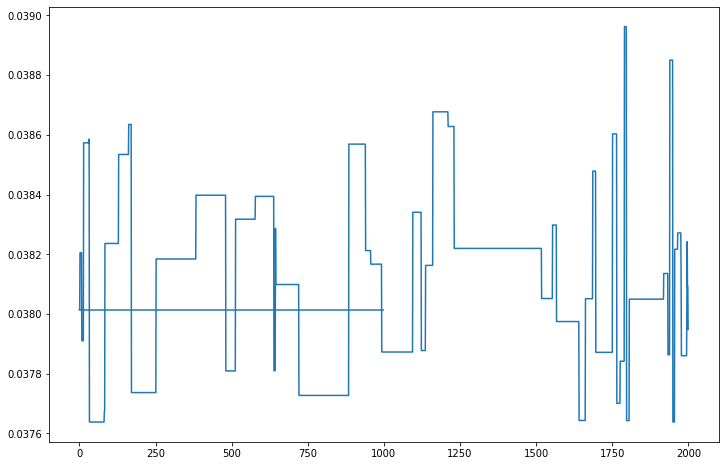

In [52]:
n_iter=1000
plt.figure(figsize=(12,8))
plt.hlines(x_opt[1],1,1000,label='beta')
plt.plot(samples[:,1])
plt.show

##### Tracé des histogrammes des lois à posteriori des paramètres $\alpha,\beta,\delta,\gamma.$

- Commencons par vérifier à partir de quel échantillon les moyennes cumulées des paramètres commencent à converger "Ergodicité"

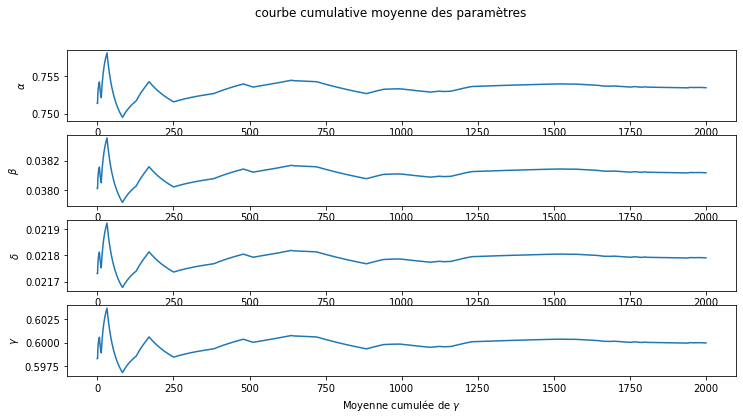

In [49]:
params_ = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
colors = ['blue', 'red', 'green', 'yellow']

plt.figure(figsize=(12,6))
plt.suptitle("courbe cumulative moyenne des paramètres")
for j in range(1, 5):
  plt.subplot(4, 1, j)
  plt.ylabel(params_[j-1])
  plt.xlabel(f"Moyenne cumulée de {params_[j-1]}")
  plt.plot(np.cumsum(samples[:, j-1])/np.arange(1, len(samples[:, j-1])+1))

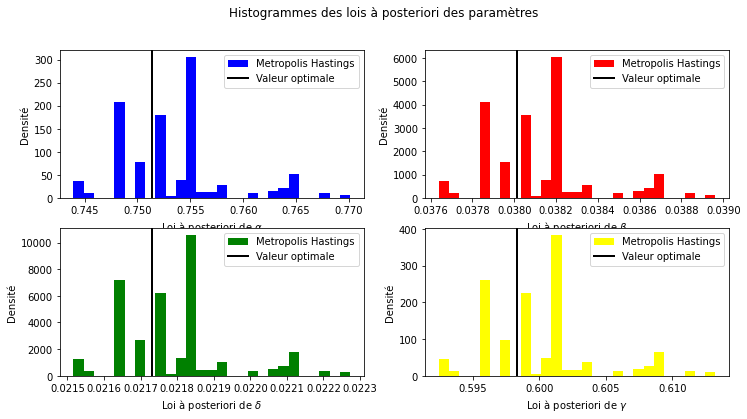

In [50]:
# On a convergence à peu près à partir de 1000
e_opt = 1000
echantillon = samples[e_opt:,:]
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des lois à posteriori des paramètres")
for j in range(1, 5):
  plt.subplot(2, 2, j)
  plt.ylabel("Densité")
  plt.xlabel(f"Loi à posteriori de {params_[j-1]}")
  n, bins, patches = plt.hist(echantillon[:, j-1], bins='auto', density=True, color=colors[j-1], label='Metropolis Hastings')
  plt.axvline(x_opt[j-1], color='k', linestyle='solid', linewidth=2, label='Valeur optimale')
  plt.legend(loc='best')

##### Tracez des histogrammes des prédictions des populations de proies et prédateurs en 1921 et en 1930.

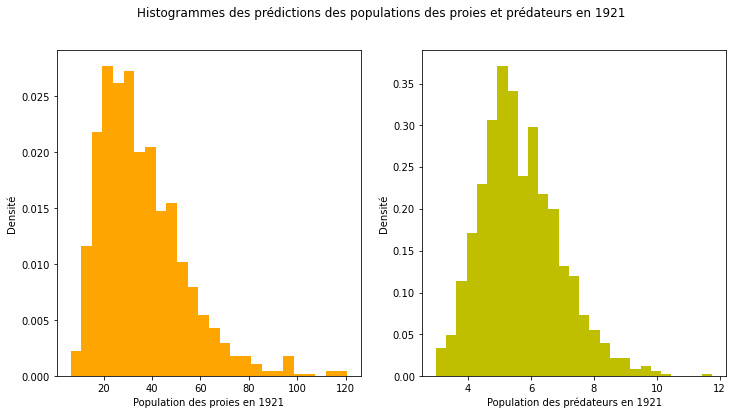

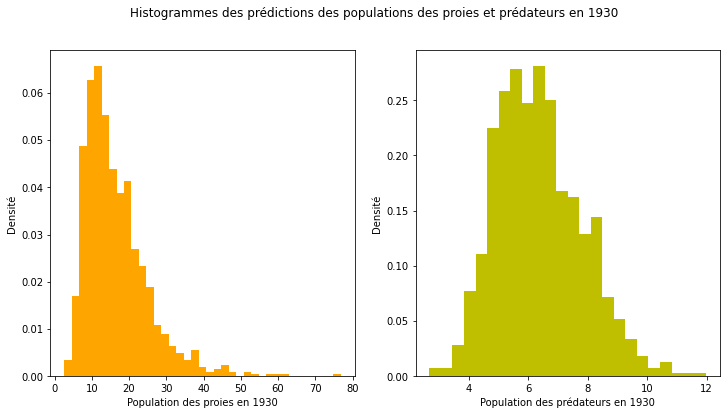

In [51]:
# Prédictions des populations de proies et prédateurs en 1921 et en 1930
# Simulation epsilon
t0 = 1900
# Calcul des prédiction pour les instants dans la listes dates
def prediction(temps):
  eps_proie = np.random.normal(0, sigma[0], size=(echantillon.shape[0],len(temps)))
  eps_preda = np.random.normal(0, sigma[1], size=(echantillon.shape[0],len(temps)))
  x = [echantillon[:,i] for i in range(6)]
  y, z = Mpred(x, dates[-1])
  return y[:, np.array(temps)-t0]*np.exp(eps_proie), z[:, np.array(temps)-t0]*np.exp(eps_preda)

temps = [1921, 1930]
proie, preda = prediction(temps)

# Histogrammes 
#1921
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1921")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1921")
n, bins, patches = plt.hist(proie[:, 0], bins='auto', density=True, color='orange')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1921")
n, bins, patches = plt.hist(preda[:, 0], bins='auto', density=True, color='y')

# 1930
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1930")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1930")
n, bins, patches = plt.hist(proie[:, 1], bins='auto', density=True, color='orange')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1930")
n, bins, patches = plt.hist(preda[:, 1], bins='auto', density=True, color='y')

#### 4.3 Calibration full-bayésienne
Dans cette section on va appliquer une approche full-bay ́esienne. On reprend la situation de la section pr ́ec ́edente et on suppose une loi a priori sur σ de la forme

$\sigma_{proie}, \sigma_{preda} \approx \mathcal{LN}(\lambda = −1,\zeta^2 = 12)$, avec $\sigma_{proie}, \sigma_{preda}$ indépendantes entre elles. Cette loi a priori est peu informative : elle est naturellement concentrée sur les réels positifs, et elle consiste à supposer qu’une valeur de $\sigma_{proie}, \sigma_{preda}$ inférieure à exp(λ − 2ζ) ≃ 0.05 ou supérieure à exp(λ + 2ζ) $\approx$ 3 est peu vraisemblable.

Dans l’approche full-bay ́esienne, la loi a posteriori de x est de la forme:
$$p(x|data) = \int_{]0,\infty[^2}p(x, σ|data) d\sigma$$


$$p(x, σ|data) ≈ p(data|x, σ)pprior(x)pprior(σ),$$
où $\approx$ signifie “à une constante multiplicative près”

La loi a posterori n’a pas d’expression explicite. Par conséquent, nous devons recourir à des algorithmes d’échantillonnage. Ici, nous sugg ́erons d’utiliser un algorithme de Metropolis-Hastings adaptatif pour  ́echantillonner (x, σ).

Une pr ́ediction de la population de proies $M_{proie(t_{new})}$ et pr ́edateurs $M_{preda(t_{new})}$ pour une année $t_{new}$ peut alors être effectuée car : 

$$\mathbb E [\phi(M_{proie}(t_{new}))] = \int_{\mathbb R} \int_{]0,\infty[^4}\phi(M_{proie}(t_{new},x))exp(σ_{proie}\epsilon)p(x,σ|data)p(\epsilon)dxd\epsilon$$

avec $p(\epsilon)=\frac{1}{\sqrt{2\pi}}exp(−\frac{\epsilon^2}{2})$.

Question 7 : reprenez la question 6 dans le cas full-bayésien.


In [64]:
# Fonction qui implémente p(data| x, sigma*)
def likelihood2(x, sigma, data_proie, data_preda):
    x = x.reshape((6,1))
    y, z = Mpred(x, 1920)
    e_proie = np.log(y/data_proie)
    e_preda = np.log(z/data_preda)
    err = np.sum(e_proie**2)/sigma[0]**2 + np.sum(e_preda**2)/sigma[1]**2
    cte = 1 / (2 * np.pi * sigma[0] * sigma[1])
    result = (cte ** 21) * np.exp(-err/2)
    return result

# On modifie la ditribution p_post p(x, sigma|data)
def posterior_density2(x,sigma, proie=data_proie, preda=data_preda):
    pdf_sigma1 = norm(-1, 1).pdf(np.log(sigma[0])) / sigma[0]
    pdf_sigma2 = norm(-1, 1).pdf(np.log(sigma[1])) / sigma[1]
    return likelihood2(x, sigma, proie, preda) * prior_density1(x) * pdf_sigma1 * pdf_sigma2

def metropolis_hastings(func, n_samples, x_init, cov, sigma_param=False):
      dim = len(x_init)
      samples = np.zeros((n_samples, dim))
      x_curr = x_init
      n_prev = 0
      for i in range(n_samples):
          # adapter la variance de la distribution de proposition
          if  i > 0:
            cov = ((n_prev - 1) / n_prev) * np.cov(samples.T)
          # générer un échantillon candidat à partir de la distribution de proposition
          x_prop = np.random.multivariate_normal(x_curr, cov)
          while verify_negativity(x_prop): # lognormal density needs positive params
            x_prop = np.random.multivariate_normal(x_curr, cov)
          # Génère la probabilité d'acceptance
          if not sigma_param:
            alpha = min(1, func(x_prop) / func(x_curr))
          else:
            alpha = min(1, func(x_prop[:-2], x_prop[-2:]) / func(x_curr[:-2], x_curr[-2:]))
          # Génère un nombre aléatoire compris entre 0 et 1 uniformémemt
          u = np.random.uniform()
          if u < alpha:
              # Accepte l'échantillon candidat
              x_curr = x_prop
          # Enregistre l'échantillon courant
          samples[i] = x_curr
          n_prev += 1

      return samples

In [65]:
# Debut Simulation
init_values = x_opt.squeeze()
init_values = np.insert(init_values, 6, sigma)
cov_init = np.diag(np.insert(zetas, 6, [1, 1]))
samples_x_sigma = metropolis_hastings(posterior_density2, n_samples=2000, x_init=init_values, cov=cov_init, sigma_param=True)

##### Visualisation de l'évolution pour $\alpha$

<function matplotlib.pyplot.show(close=None, block=None)>

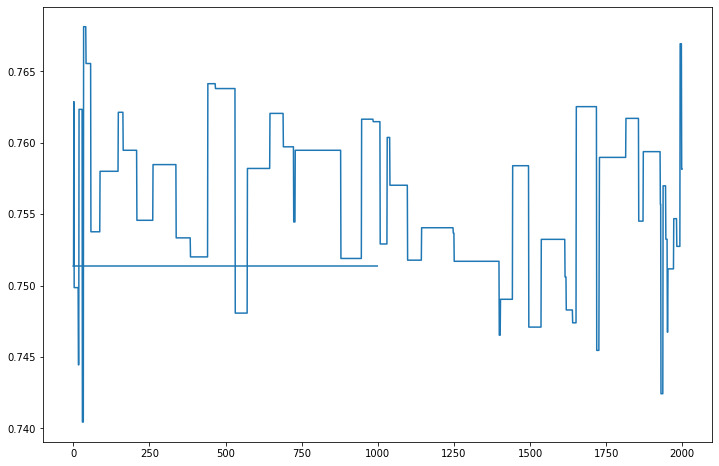

In [69]:
n_iter=1000
plt.figure(figsize=(12,8))
plt.hlines(x_opt[0],1,1000,label='beta')
plt.plot(samples[:,0])
plt.show

##### Tracé des histogrammes des lois à posteriori des paramètres $\alpha,\beta,\delta,\gamma.$

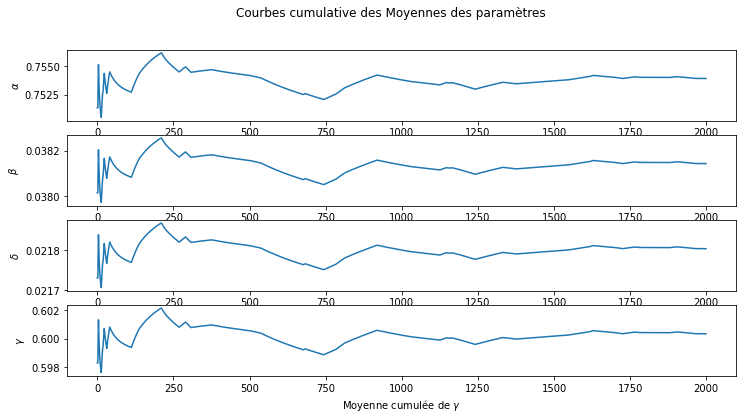

In [70]:
params_ = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
colors = ['blue', 'red', 'green', 'yellow']
# On commence par vérifier à partir de quel échantillon les moyennes commencent à converger "Ergodicité"
plt.figure(figsize=(12,6))
plt.suptitle("Courbes cumulative des Moyennes des paramètres")
for j in range(1, 5):
  plt.subplot(4, 1, j)
  plt.ylabel(params_[j-1])
  plt.xlabel(f"Moyenne cumulée de {params_[j-1]}")
  plt.plot(np.cumsum(samples_x_sigma[:, j-1])/np.arange(1, len(samples_x_sigma[:, j-1])+1))

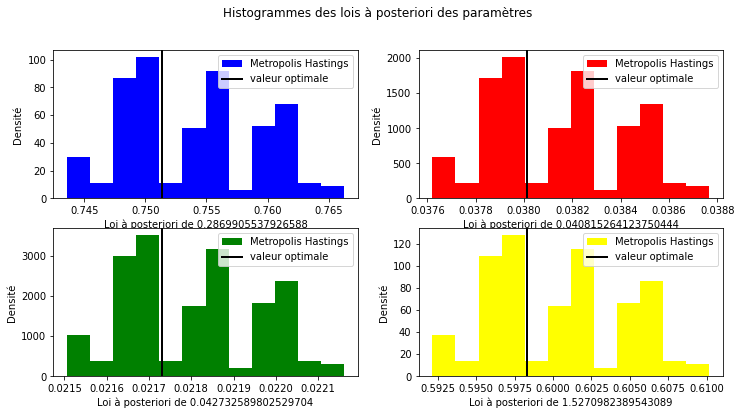

In [75]:
# On a convergence à peu près à partir de 700
e_opt = 1000
echantillon = samples_x_sigma[e_opt:,:]
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des lois à posteriori des paramètres")
for j in range(1, 5):
  plt.subplot(2, 2, j)
  plt.ylabel("Densité")
  plt.xlabel(f"Loi à posteriori de {params[j-1]}")
  n, bins, patches = plt.hist(echantillon[:, j-1], bins='auto', density=True, color=colors[j-1], label='Metropolis Hastings')
  plt.axvline(x_opt[j-1], color='k', linestyle='solid', linewidth=2, label='valeur optimale')
  plt.legend(loc='best')

##### Tracé des histogrammes des lois à posteriori des paramètres $\alpha,\beta,\delta,\gamma.$

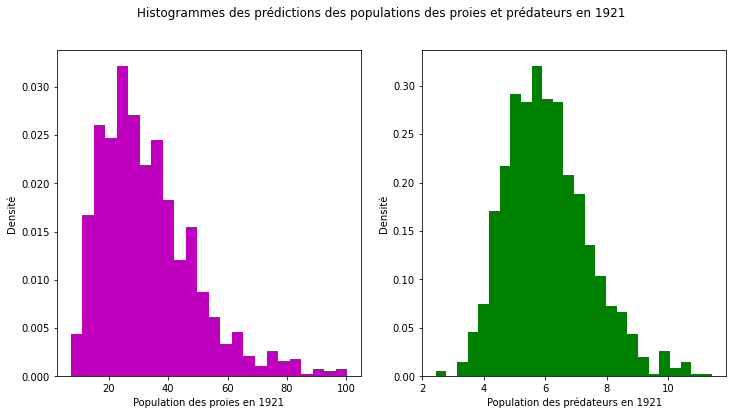

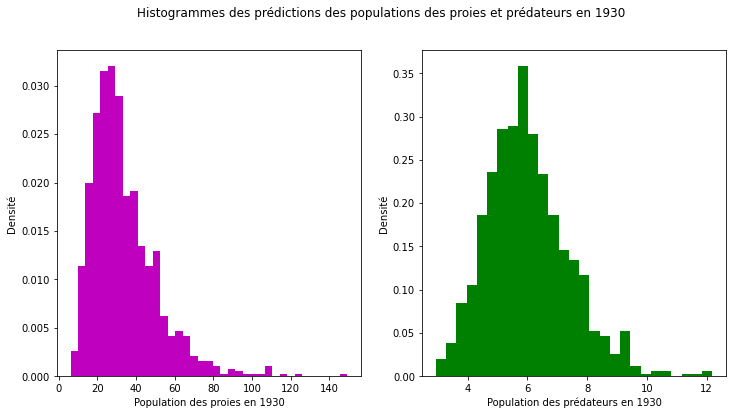

In [74]:
# Prédictions des populations de proies et prédateurs en 1921 et en 1930
def prediction(temps):
  shape_echantillon = echantillon.shape[0]
  x = [echantillon[:,i] for i in range(6)]
  sigma = np.array([echantillon[:,i] for i in range(6,8)])
  eps_proie = np.random.normal(0, sigma[0].reshape(shape_echantillon, 1), size=(shape_echantillon,len(temps)))
  eps_preda = np.random.normal(0, sigma[1].reshape(shape_echantillon, 1), size=(shape_echantillon,len(temps)))
  y, z = resolution(x, temps[-1])
  return y[:, np.array(temps)-t0]*np.exp(eps_proie), z[:, np.array(temps)-t0]*np.exp(eps_preda)

temps = [1921, 1930]
proie, preda =  prediction(temps)

# Histogrammes 
#1921
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1921")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1921")
n, bins, patches = plt.hist(proie[:, 0], bins='auto', density=True, color='m')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1921")
n, bins, patches = plt.hist(preda[:, 0], bins='auto', density=True, color='g')

# 1930
plt.figure(figsize=(12,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1930")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1930")
n, bins, patches = plt.hist(proie[:, 1], bins='auto', density=True, color='m')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1930")
n, bins, patches = plt.hist(preda[:, 1], bins='auto', density=True, color='g')